### Load Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime as dt
import math
import seaborn as sns

# Import Custom Module
import OeconToolbox as ott
import LoanPortfolioTool as pft

%load_ext autoreload
%autoreload 2
%matplotlib inline

### [OPTIONAL] Set Matplotlib Style

In [2]:
matplotlib.style.use('default')

matplotlib.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    "font.size": 10})
matplotlib.path.should_simplify = True

sns.set_style("ticks")

cm = 1/2.54
textwidth = 13.998 / 2.54

## Import Cumulative Default Table

In [3]:
DefTable = pd.read_excel("CumulativeDefaultTable.xlsx",header=[0],index_col=[0],skipfooter=5,usecols="A:K")
DefTable.round(2)

,1,2,3,4,5,6,7,8,9,10
AAA,0.00,0.03,0.10,0.19,0.27,0.37,0.41,0.46,0.52,0.58
AA,0.02,0.06,0.11,0.21,0.30,0.41,0.49,0.56,0.63,0.70
A,0.05,0.13,0.22,0.33,0.46,0.60,0.76,0.90,1.05,1.20
BBB,0.16,0.43,0.75,1.14,1.54,1.94,2.27,2.61,2.94,3.24
BB,0.63,1.93,3.46,4.99,6.43,7.75,8.89,9.90,10.82,11.64
B,3.34,7.80,11.75,14.89,17.35,19.36,20.99,22.31,23.50,24.62


# Simulating a Portfolio of loans
The SPV portfolio consists of $J$ loans from identical corporate issuers with a single class of debt outstanding. The parameters of the issuers is identical to those described in the 'Collateral Dynamics.ipynb' notebook.

## Parameters of the Corporate Issuers

In [4]:
V0 = 100      # Initial Asset Value
rf = .035     # Risk-Free Rate
rm = .105     # Market Return
beta = .8     # Firm CAPM Coefficient
sigma_i = .25 # Idiosyncratic Risk
sigma_m = .14 # Market Risk
ttm = 5       # Time to Maturity of Debt
penalty = 0   # Penalty on prepayment

Auxiliary Calculations

In [5]:
mu = rf + beta * (rm - rf)
sigma = ott.sigma_beta_adj(beta, sigma_m, sigma_i)
face_value = ott.facevalue_from_probability(DefTable.loc["B", ttm] / 100, V0, ttm, mu, sigma)
market_value = ott.mv_bond(V0, face_value, ttm, rf, sigma)
b_loan_yield = ott.zero_yield(market_value,face_value, ttm)
# Results from Collateral Dynamics Notebook
mv_call = 54.71780723807047
b_callable_yield = ott.zero_yield(mv_call,face_value, ttm)

## Parameters of the SPV

In [6]:
J = 125    # number of loans
N = 250000 # Number of simulated portfolios

In [7]:
loan_portfolios = pft.Loan_Portfolios(V = V0,
                                      B = face_value, 
                                      T = ttm,
                                      rf = rf,
                                      rm = rm,
                                      beta = beta,
                                      sigmaM = sigma_m,
                                      sigmaI = sigma_i,
                                      j=J,
                                      n=N,
                                      seed=1234)

# Modelling the SPV Dynamics without Prepayment on Collateral Assets

In [8]:
max_spv_cash_flows = face_value * J
initial_market_value = market_value * J
print("The absolute maximum payoff: {0:0.2f} with initial market value: {1:0.2f}".format(max_spv_cash_flows,initial_market_value))

The absolute maximum payoff: 9180.30 with initial market value: 6990.38


Total SPV payoffs (under Q and P-measure respectively)

In [9]:
SPV_Q, _ = loan_portfolios.no_prepayments(risk_neutral = True, paths = False)

In [10]:
SPV_P, M = loan_portfolios.no_prepayments(risk_neutral = False, paths = False)

## Cash Flows to Each Tranche

In [11]:
ott.zero_yield(SPV_Q.mean() * np.exp(-rf * ttm),max_spv_cash_flows,ttm) * 100

5.450229313606501

In [12]:
tranches_no_prepay = ott.tranche_sizes(DefTable,SPV_P,ttm,7)

In [13]:
pd.DataFrame({'Cash Flows':tranches_no_prepay,
              'Sum':tranches_no_prepay.cumsum(),
              'Percent of Total':np.divide(tranches_no_prepay.cumsum(),tranches_no_prepay.cumsum()[-1])*100
             },["AAA","AA","A","BBB","BB","B","Equity"]).round(1)

,Cash Flows,Sum,Percent of Total
AAA,7233.1,7233.1,78.8
AA,32.6,7265.7,79.1
A,125.6,7391.3,80.5
BBB,358.1,7749.4,84.4
BB,442.0,8191.4,89.2
B,317.9,8509.2,92.7
Equity,671.1,9180.3,100.0


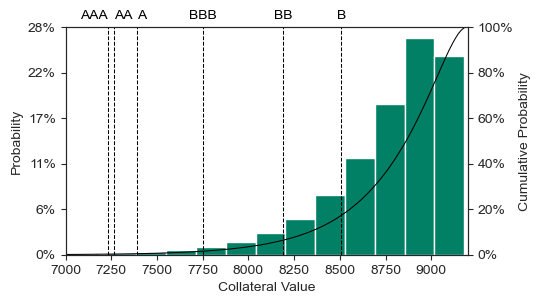

In [14]:
plt.figure(figsize=(textwidth, 8*cm))
palette = sns.color_palette("summer", n_colors=6, as_cmap=True)

simulations = SPV_P

min_ = 7000
max_ = 9200
ax = sns.histplot(data=simulations, bins=25, color=palette(1), stat='probability', alpha=1)
plt.ylabel("Probability")
maxy = round(ax.get_ylim()[1],2)

plt.ylim([0, maxy])
plt.yticks(np.linspace(0, maxy, 6),[str(int(round(x,2)*100))+"%" for x in np.linspace(0, maxy, 6)])

plt.xlim([min_,max_])
plt.xlabel("Collateral Value")

for rating, def_prob in DefTable[ttm].items(): 
    value = np.quantile(simulations, def_prob/100)
    plt.vlines(value,0,maxy*1.05,color='k',linestyles='--',linewidth=0.75)
    if rating == 'AAA':
        plt.text(value,maxy*1.05,s=rating,ha='right',va='center',color='k')
    elif rating == 'AA' or rating == 'A':
        plt.text(value,maxy*1.05,s=rating,ha='left',va='center',color='k')
    else:
        plt.text(value,maxy*1.05,s=rating,ha='center',va='center',color='k')

ax2 = ax.twinx()
ax2 = sns.ecdfplot(data=simulations, color='k',linewidth=0.75, ax=ax2, stat='proportion')
plt.ylabel("Cumulative Probability")
plt.ylim([0,1])
plt.yticks(np.linspace(0, 1, 6),["0%","20%","40%","60%","80%","100%"])

plt.tight_layout()

#plt.savefig("pic.pdf", format='pdf', bbox_inches='tight')

plt.show()

Data For Scatterplots

In [15]:
SPV_P_small = np.random.RandomState(1234).choice(SPV_P,size=2500)
M_small = np.random.RandomState(1234).choice(M,size=2500)

In [16]:
data_no_prepay = pd.DataFrame({'SPV':SPV_P_small/ max_spv_cash_flows,
                               'Market Factor':M_small / ttm,
                               'AAA':ott.clo_payoffs(SPV_P_small,tranches_no_prepay)[0]/ tranches_no_prepay[0],
                               'AA':ott.clo_payoffs(SPV_P_small,tranches_no_prepay)[1]/ tranches_no_prepay[1],
                               'A':ott.clo_payoffs(SPV_P_small,tranches_no_prepay)[2] / tranches_no_prepay[2],
                               'BBB':ott.clo_payoffs(SPV_P_small,tranches_no_prepay)[3] / tranches_no_prepay[3],
                               'BB':ott.clo_payoffs(SPV_P_small,tranches_no_prepay)[4] / tranches_no_prepay[4],
                               'B':ott.clo_payoffs(SPV_P_small,tranches_no_prepay)[5] / tranches_no_prepay[5],
                               'Equity':ott.clo_payoffs(SPV_P_small,tranches_no_prepay)[6]/ tranches_no_prepay[6]})
data_no_prepay.head()

,SPV,Market Factor,AAA,AA,A,BBB,BB,B,Equity
0,0.990824,0.249813,1.0,1.0,1.0,1.0,1.0,1.0,0.874467
1,0.982318,0.007552,1.0,1.0,1.0,1.0,1.0,1.0,0.758100
2,0.976469,0.196481,1.0,1.0,1.0,1.0,1.0,1.0,0.678097
3,0.964409,-0.136603,1.0,1.0,1.0,1.0,1.0,1.0,0.513102
4,0.982938,0.328542,1.0,1.0,1.0,1.0,1.0,1.0,0.766591


In [17]:
maximum_norm_payoff = max_spv_cash_flows / initial_market_value * 100
print('The maximum normalized payoff is: {0:0.2f}'.format(maximum_norm_payoff))

The maximum normalized payoff is: 131.33


In [18]:
no_prepay_tab = DefTable[[ttm]].copy()
no_prepay_tab.rename(columns={5:'Default Probability'},inplace=True)
no_prepay_tab['Face Value'] = (np.quantile(SPV_P, no_prepay_tab['Default Probability']/100) / initial_market_value) * 100

In [19]:
for rating in no_prepay_tab.index:
    no_prepay_tab.loc[rating, 'Market Value'] = (np.minimum(SPV_Q,
                                                            np.quantile(SPV_P,
                                                                        no_prepay_tab.loc[rating, 'Default Probability']/100
                                                                       )).mean() * np.exp(-rf*ttm) / initial_market_value) * 100

Preliminary Table before "tranching"

In [20]:
no_prepay_tab.round(2)

,Default Probability,Face Value,Market Value
AAA,0.27,103.47,86.64
AA,0.30,103.94,87.02
A,0.46,105.73,88.44
BBB,1.54,110.86,92.31
BB,6.43,117.18,96.41
B,17.35,121.73,98.56


Tranching:

In [21]:
no_prepay_tab.loc[:,'Face Value':'Market Value'] = no_prepay_tab.loc[:,'Face Value':'Market Value'] - no_prepay_tab.loc[:,'Face Value':'Market Value'].shift(1)
no_prepay_tab.loc['AAA','Face Value'] = (np.quantile(SPV_P, no_prepay_tab.loc['AAA','Default Probability']/100) / initial_market_value) * 100
no_prepay_tab.loc['AAA','Market Value'] = (np.minimum(SPV_Q, np.quantile(SPV_P, no_prepay_tab.loc['AAA', 'Default Probability']/100)).mean() * np.exp(-rf*ttm) / initial_market_value) * 100
no_prepay_tab['Yield'] = ott.zero_yield(no_prepay_tab['Market Value'], no_prepay_tab['Face Value'], ttm) * 100
no_prepay_tab.loc['Equity','Market Value'] = 100 - no_prepay_tab['Market Value'].sum(axis=0)

In [22]:
no_prepay_tab.round(2)

,Default Probability,Face Value,Market Value,Yield
AAA,0.27,103.47,86.64,3.55
AA,0.30,0.47,0.37,4.48
A,0.46,1.80,1.42,4.69
BBB,1.54,5.12,3.87,5.61
BB,6.43,6.32,4.11,8.63
B,17.35,4.55,2.15,15.00
Equity,NaN,NaN,1.44,NaN


# Modelling the SPV Dynamics with Prepayments on Collateral Assets

In [24]:
SPV_Q_pp, _, equity_Q_pp = loan_portfolios.with_prepayments(default_table = DefTable,
                                                            rating='B',
                                                            mv_callable=mv_call,
                                                            risk_neutral = True,
                                                            penalty=penalty)

In [28]:
SPV_P_pp, M_pp, equity_P_pp = loan_portfolios.with_prepayments(default_table = DefTable,
                                                               rating='B',
                                                               mv_callable=mv_call,
                                                               risk_neutral = False,
                                                               penalty=penalty)

## Cash Flows to Tranches

In [29]:
tranches_prepay = ott.tranche_sizes(DefTable,SPV_P_pp,ttm,7)

In [30]:
pd.DataFrame({'Cash Flows':tranches_prepay,
              'Sum':tranches_prepay.cumsum(),
              'Percent of Total':np.divide(tranches_prepay,tranches_prepay.cumsum()[-1])*100
             },["AAA","AA","A","BBB","BB","B","Equity"]).round(1)

,Cash Flows,Sum,Percent of Total
AAA,6752.6,6752.6,77.2
AA,31.2,6783.8,0.4
A,115.4,6899.2,1.3
BBB,336.2,7235.4,3.8
BB,411.3,7646.6,4.7
B,296.6,7943.2,3.4
Equity,801.9,8745.1,9.2


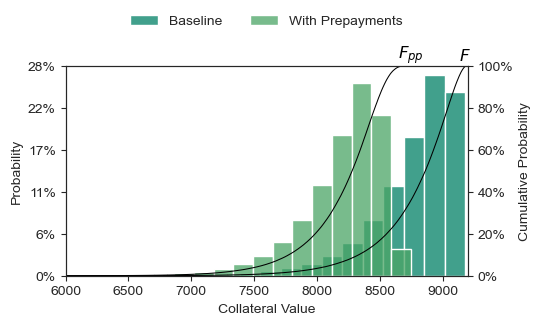

In [31]:
plt.figure(figsize=(textwidth, 9*cm))
palette = sns.color_palette("summer", n_colors=6, as_cmap=True)

simulations = SPV_P
simulations_pp = SPV_P_pp

min_ = 6000
max_ = 9200
ax = sns.histplot(data=simulations, bins=25, color=palette(1), stat='probability', alpha=0.75)
ax = sns.histplot(data=simulations_pp, bins=25, color=palette(75), stat='probability', alpha=0.75)

plt.ylabel("Probability")
maxy = round(ax.get_ylim()[1],2)

plt.ylim([0, maxy])
plt.yticks(np.linspace(0, maxy, 6),[str(int(round(x,2)*100))+"%" for x in np.linspace(0, maxy, 6)])
plt.legend(['Baseline','With Prepayments'],loc="upper center", bbox_to_anchor=(0.5, 1.3, 0, 0),ncol=2, frameon=False)


plt.xlim([min_,max_])
plt.xlabel("Collateral Value")

ax2 = ax.twinx()
ax2 = sns.ecdfplot(data=simulations, color='k',linewidth=0.75, ax=ax2, stat='proportion')
ax2 = sns.ecdfplot(data=simulations_pp, color='k',linewidth=0.75, ax=ax2, stat='proportion')

plt.text(np.quantile(simulations_pp, 1),1.05,s="$F_{pp}$",ha='center',va='center',color='k',size=12)
plt.text(np.quantile(simulations, 1),1.05,s="$F$",ha='center',va='center',color='k',size=12)

plt.ylabel("Cumulative Probability")
plt.ylim([0,1])
plt.yticks(np.linspace(0, 1, 6),["0%","20%","40%","60%","80%","100%"])

plt.tight_layout()

#plt.savefig("ColValwPP_P.pdf", format='pdf', bbox_inches='tight')

plt.show()

Data for Scatterplots

In [32]:
SPV_P_pp_small = np.random.RandomState(1234).choice(SPV_P_pp,size=2500)
M_pp_small = np.random.RandomState(1234).choice(M_pp,size=2500)
equity_P_pp_small = np.random.RandomState(1234).choice(equity_P_pp,size=2500)

In [33]:
data_prepay = pd.DataFrame({'SPV':SPV_P_pp_small/ max_spv_cash_flows,
                             'Market Factor':M_pp_small / ttm,
                             'AAA':ott.clo_payoffs(SPV_P_pp_small,tranches_prepay)[0]/ tranches_prepay[0],
                             'AA':ott.clo_payoffs(SPV_P_pp_small,tranches_prepay)[1]/ tranches_prepay[1],
                             'A':ott.clo_payoffs(SPV_P_pp_small,tranches_prepay)[2] / tranches_prepay[2],
                             'BBB':ott.clo_payoffs(SPV_P_pp_small,tranches_prepay)[3] / tranches_prepay[3],
                             'BB':ott.clo_payoffs(SPV_P_pp_small,tranches_prepay)[4] / tranches_prepay[4],
                             'B':ott.clo_payoffs(SPV_P_pp_small,tranches_prepay)[5] / tranches_prepay[5],
                             'Equity':(ott.clo_payoffs(SPV_P_pp_small,tranches_prepay)[6] + equity_P_pp_small) / (tranches_prepay[6] + max(equity_P_pp_small))})
data_prepay

,SPV,Market Factor,AAA,AA,A,BBB,BB,B,Equity
0,0.928588,0.052765,1.0,1.0,1.0,1.0,1.0,1.0,0.624967
1,0.918883,0.480935,1.0,1.0,1.0,1.0,1.0,1.0,0.611809
2,0.912871,0.372519,1.0,1.0,1.0,1.0,1.0,1.0,0.549262
3,0.901015,-0.091125,1.0,1.0,1.0,1.0,1.0,1.0,0.485061
4,0.919537,0.408927,1.0,1.0,1.0,1.0,1.0,1.0,0.591666
...,...,...,...,...,...,...,...,...,...
2495,0.915463,0.438594,1.0,1.0,1.0,1.0,1.0,1.0,0.607500
2496,0.905461,0.085152,1.0,1.0,1.0,1.0,1.0,1.0,0.487304
2497,0.920453,0.302135,1.0,1.0,1.0,1.0,1.0,1.0,0.619021
2498,0.877126,-0.356956,1.0,1.0,1.0,1.0,1.0,1.0,0.235630


Generate Tables

In [34]:
initial_market_value_prepayment = mv_call * J

In [35]:
maximum_norm_payoff = max_spv_cash_flows / initial_market_value_prepayment * 100
print('The maximum normalized payoff is: {0:0.2f}'.format(maximum_norm_payoff))

The maximum normalized payoff is: 134.22


In [36]:
prepay_tab = DefTable[[ttm]].copy()
prepay_tab.rename(columns={5:'Default Probability'},inplace=True)
prepay_tab['Face Value'] = (np.quantile(SPV_P_pp, prepay_tab['Default Probability']/100) / initial_market_value) * 100

In [37]:
for rating in prepay_tab.index:
    prepay_tab.loc[rating, 'Market Value'] = (np.minimum(SPV_Q_pp,
                                                         np.quantile(SPV_P_pp,
                                                                     prepay_tab.loc[rating, 'Default Probability']/100
                                                                    )).mean() * np.exp(-rf*ttm) / initial_market_value) * 100

Preliminary Table before Tranching

In [38]:
prepay_tab.round(2)

,Default Probability,Face Value,Market Value
AAA,0.27,96.60,80.90
AA,0.30,97.04,81.26
A,0.46,98.70,82.57
BBB,1.54,103.50,86.21
BB,6.43,109.39,90.05
B,17.35,113.63,92.08


Tranching

In [39]:
prepay_tab.loc[:,'Face Value':'Market Value'] = prepay_tab.loc[:,'Face Value':'Market Value'] - prepay_tab.loc[:,'Face Value':'Market Value'].shift(1)
prepay_tab.loc['AAA','Face Value'] = (np.quantile(SPV_P_pp, prepay_tab.loc['AAA','Default Probability']/100) / initial_market_value) * 100
prepay_tab.loc['AAA','Market Value'] = (np.minimum(SPV_Q_pp, np.quantile(SPV_P_pp, prepay_tab.loc['AAA', 'Default Probability']/100)).mean() * np.exp(-rf*ttm) / initial_market_value) * 100
prepay_tab['Yield'] = ott.zero_yield(prepay_tab['Market Value'], prepay_tab['Face Value'], ttm) * 100
prepay_tab.loc['Equity','Market Value'] = initial_market_value_prepayment/initial_market_value * 100 - prepay_tab['Market Value'].sum(axis=0)

In [40]:
prepay_tab.round(2)

,Default Probability,Face Value,Market Value,Yield
AAA,0.27,96.60,80.90,3.55
AA,0.30,0.45,0.36,4.43
A,0.46,1.65,1.31,4.63
BBB,1.54,4.81,3.65,5.54
BB,6.43,5.88,3.84,8.53
B,17.35,4.24,2.02,14.80
Equity,NaN,NaN,5.77,NaN


Comparison with no prepayment case

In [41]:
no_prepay_tab.round(2)

,Default Probability,Face Value,Market Value,Yield
AAA,0.27,103.47,86.64,3.55
AA,0.30,0.47,0.37,4.48
A,0.46,1.80,1.42,4.69
BBB,1.54,5.12,3.87,5.61
BB,6.43,6.32,4.11,8.63
B,17.35,4.55,2.15,15.00
Equity,NaN,NaN,1.44,NaN


Create Results Table

In [45]:
final_df = pd.concat([no_prepay_tab[['Default Probability','Face Value','Yield']], prepay_tab[['Market Value']]], axis=1,sort=False)
final_df['Adj. Yield'] = ott.zero_yield(final_df['Market Value'], final_df['Face Value'], ttm) * 100
final_df['Adj. Spread'] = final_df['Adj. Yield'] - rf * 100
final_df['Mispricing'] = final_df['Adj. Yield'] - final_df['Yield']

final_df[['Default Probability', 'Face Value', 'Market Value', 'Yield', 'Adj. Yield', 'Adj. Spread', 'Mispricing']].round(2)

,Default Probability,Face Value,Market Value,Yield,Adj. Yield,Adj. Spread,Mispricing
AAA,0.27,103.47,80.90,3.55,4.92,1.42,1.37
AA,0.30,0.47,0.36,4.48,5.27,1.77,0.79
A,0.46,1.80,1.31,4.69,6.32,2.82,1.64
BBB,1.54,5.12,3.65,5.61,6.81,3.31,1.20
BB,6.43,6.32,3.84,8.63,9.97,6.47,1.34
B,17.35,4.55,2.02,15.00,16.18,12.68,1.19
Equity,NaN,NaN,5.77,NaN,NaN,NaN,NaN


In [46]:
total_mispricing = (final_df.loc['AAA':'B','Market Value'] * final_df['Mispricing'] / final_df.loc['AAA':'B','Market Value'].sum()).sum()
print("The total mispricing given the Parameters is: {0:0.2f}%".format(total_mispricing))

The total mispricing given the Parameters is: 1.36%


In [47]:
print(
    """
    WACD for the portfolios is:\n
    Correctly Priced w/ Prepayments: {0:0.2f}%\n
    Correctly Priced w/o Prepayments: {1:0.2f}%\n
    Mispriced: {2:0.2f}%
    """.format(
        ott.zero_yield(prepay_tab.loc['AAA':'B','Market Value'].sum(),prepay_tab['Face Value'].sum(),ttm) * 100,
        ott.zero_yield(no_prepay_tab.loc['AAA':'B','Market Value'].sum(),no_prepay_tab['Face Value'].sum(),ttm) * 100,
        ott.zero_yield(final_df.loc['AAA':'B','Market Value'].sum(),final_df['Face Value'].sum(),ttm) * 100)
)


    WACD for the portfolios is:

    Correctly Priced w/ Prepayments: 4.21%

    Correctly Priced w/o Prepayments: 4.22%

    Mispriced: 5.58%
    


# Create Scatterplots

In [48]:
data_mispriced = pd.DataFrame({'SPV':SPV_P_pp_small/ max_spv_cash_flows,
                               'Market Factor':M_pp_small / ttm,
                               'AAA':ott.clo_payoffs(SPV_P_pp_small,tranches_no_prepay)[0]/ tranches_no_prepay[0],
                               'AA':ott.clo_payoffs(SPV_P_pp_small,tranches_no_prepay)[1]/ tranches_no_prepay[1],
                               'A':ott.clo_payoffs(SPV_P_pp_small,tranches_no_prepay)[2] / tranches_no_prepay[2],
                               'BBB':ott.clo_payoffs(SPV_P_pp_small,tranches_no_prepay)[3] / tranches_no_prepay[3],
                               'BB':ott.clo_payoffs(SPV_P_pp_small,tranches_no_prepay)[4] / tranches_no_prepay[4],
                               'B':ott.clo_payoffs(SPV_P_pp_small,tranches_no_prepay)[5] / tranches_no_prepay[5],
                               'Equity':(ott.clo_payoffs(SPV_P_pp_small,tranches_no_prepay)[6] + equity_P_pp_small) / (tranches_no_prepay[6] + max(equity_P_pp_small))})
data_mispriced

,SPV,Market Factor,AAA,AA,A,BBB,BB,B,Equity
0,0.928588,0.052765,1.0,1.0,1.0,1.0,1.000000,1.000000,0.229308
1,0.918883,0.480935,1.0,1.0,1.0,1.0,1.000000,0.768430,0.274888
2,0.912871,0.372519,1.0,1.0,1.0,1.0,1.000000,0.594801,0.250750
3,0.901015,-0.091125,1.0,1.0,1.0,1.0,1.000000,0.252389,0.268618
4,0.919537,0.408927,1.0,1.0,1.0,1.0,1.000000,0.787311,0.247688
...,...,...,...,...,...,...,...,...,...
2495,0.915463,0.438594,1.0,1.0,1.0,1.0,1.000000,0.669648,0.295774
2496,0.905461,0.085152,1.0,1.0,1.0,1.0,1.000000,0.380803,0.237749
2497,0.920453,0.302135,1.0,1.0,1.0,1.0,1.000000,0.813759,0.271098
2498,0.877126,-0.356956,1.0,1.0,1.0,1.0,0.685354,0.000000,0.171706



        The mean payoffs to the Equity-tranche is 0.47 for the base case and 0.25 for the mispriced
        

        The mean payoffs to the SPV-tranche is 0.96 for the base case and 0.89 for the mispriced
        

        The mean payoffs to the AA-tranche is 1.00 for the base case and 0.99 for the mispriced
        

        The mean payoffs to the AAA-tranche is 1.00 for the base case and 1.00 for the mispriced
        

        The mean payoffs to the BBB-tranche is 0.99 for the base case and 0.95 for the mispriced
        

        The mean payoffs to the A-tranche is 1.00 for the base case and 0.98 for the mispriced
        

        The mean payoffs to the B-tranche is 0.89 for the base case and 0.38 for the mispriced
        

        The mean payoffs to the BB-tranche is 0.97 for the base case and 0.79 for the mispriced
        


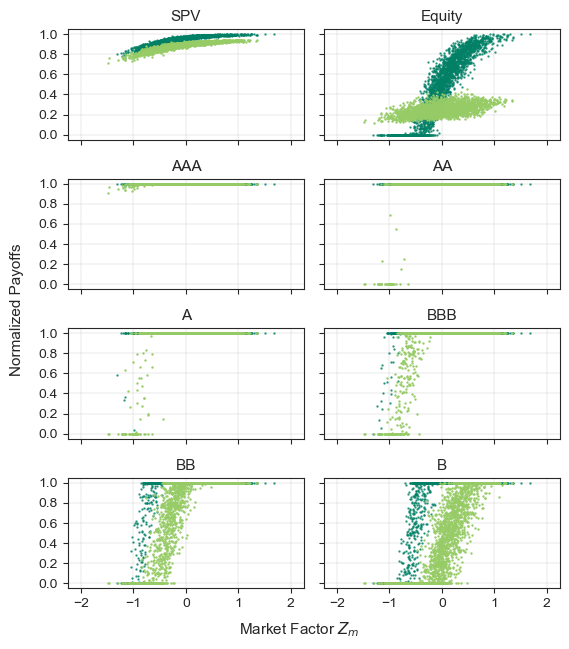

In [49]:
fig, axs = plt.subplots(ncols=2,nrows=4,sharex=True,sharey=True)

palette = sns.color_palette("summer", n_colors=6, as_cmap=True)

fig.text(0.5, -0.015, 'Market Factor $Z_{m}$', ha='center', size=11)
fig.text(-0.025, 0.5, 'Normalized Payoffs', va='center', rotation='vertical', size=11)

i,j = 0,0
for tranche in ["Equity","SPV","AA","AAA","BBB","A","B","BB"]:
    if j == 0: j = 1
    else: j = 0
    axs[i,j].scatter(x=data_no_prepay['Market Factor'], y = data_no_prepay[tranche], s= 0.5, color=palette(1),alpha=0.75)
    axs[i,j].scatter(x=data_mispriced['Market Factor'], y = data_mispriced[tranche], s= 0.5, color=palette(150))
    axs[i,j].set_title(tranche, size=11)
    
    print(
        """
        The mean payoffs to the {0}-tranche is {1:0.2f} for the base case and {2:0.2f} for the mispriced
        """.format(tranche, round(data_no_prepay[tranche].mean(),2), round(data_mispriced[tranche].mean(),2)))
    
    axs[i,j].set_xlabel('')
    axs[i,j].set_xlim([-2.25,2.25])
    axs[i,j].set_xticks([-2,-1,0,1,2])
    
    axs[i,j].set_ylabel('')
    axs[i,j].set_ylim([-0.05,1.05])
    axs[i,j].set_yticks([0,0.2,0.4,0.6,0.8,1])
    axs[i,j].grid(lw=0.3)
    if j == 0: i = i + 1

fig.set_size_inches(textwidth, 16*cm)
fig.tight_layout()

#fig.savefig("Payoffs.pdf", bbox_inches='tight', format='pdf')

plt.show()

# Return on Equity Analysis

In [50]:
equity_payoffs = ott.clo_payoffs(SPV_P,tranches_no_prepay)[6]
equity_payoffs_pp = ott.clo_payoffs(SPV_P_pp,tranches_prepay)[6] + equity_P_pp
equity_payoffs,equity_payoffs_pp

(array([  0.        ,   0.        ,   0.        , ..., 671.06262338,
        671.06262338, 671.06262338]),
 array([ 97.12962129, 157.42243283, 110.11126839, ..., 983.28665369,
        999.36423868, 998.02744455]))

In [51]:
equity_mv = (np.minimum(SPV_Q, np.quantile(SPV_P,1)).mean() - np.minimum(SPV_Q,np.quantile(SPV_P,DefTable.loc['B',ttm]/100)).mean()) * np.exp(-rf*ttm)
equity_mv_pp = (np.minimum(SPV_Q_pp, np.quantile(SPV_P_pp,1)).mean() - np.minimum(SPV_Q_pp,np.quantile(SPV_P_pp,DefTable.loc['B',ttm]/100)).mean() + equity_Q_pp.mean()) * np.exp(-rf*ttm)
equity_mv, equity_mv_pp

(100.60065506353396, 324.2646761285653)

In [52]:
ROE = (equity_payoffs - equity_mv) / equity_mv
ROE_pp = (equity_payoffs_pp - equity_mv_pp) / equity_mv_pp
ROE,ROE_pp

(array([-1.        , -1.        , -1.        , ...,  5.67055918,
         5.67055918,  5.67055918]),
 array([-0.70046191, -0.51452488, -0.6604278 , ...,  2.03235821,
         2.08193989,  2.07781734]))

In [53]:
np.where(ROE<0,1,0).mean()*100,np.where(ROE==-1,1,0).mean()*100, np.where(ROE_pp<0,1,0).mean()*100

(23.663999999999998, 17.349999999999998, 18.0752)

In [54]:
ann_std = ROE.std()*np.sqrt(1/ttm)
ann_std_pp = ROE_pp.std() * np.sqrt(1/ttm)
ann_std, ann_std_pp

(0.9549952648045796, 0.3244639699890512)

In [55]:
ann_ROE = (1+ROE)**(1/ttm)-1
ann_ROE_pp = (1+ROE_pp)**(1/ttm)-1
ann_ROE, ann_ROE_pp

(array([-1.        , -1.        , -1.        , ...,  0.46161317,
         0.46161317,  0.46161317]),
 array([-0.21423911, -0.13456711, -0.19427577, ...,  0.24840673,
         0.25246279,  0.25212754]))

In [56]:
ann_mean_ROE = (1+ROE.mean())**(1/ttm)-1
ann_mean_ROE_pp = (1+ROE_pp.mean())**(1/ttm)-1
ann_mean_ROE, ann_mean_ROE_pp

(0.25984674918347794, 0.13503654469541093)

In [57]:
sharpe = (ann_mean_ROE - rf) / ann_std
sharpe_pp = (ann_mean_ROE_pp - rf) / ann_std_pp
sharpe, sharpe_pp

(0.23544278958230044, 0.30831326109579005)

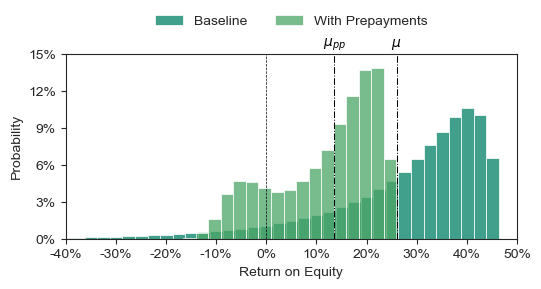

In [60]:
plt.figure(figsize=(textwidth, 8*cm))
palette = sns.color_palette("summer", n_colors=6, as_cmap=True)

simulations = ann_ROE[ann_ROE>-1]
simulations_pp = ann_ROE_pp[ann_ROE_pp>-1]

min_ = -0.4
max_ = 0.5
ax = sns.histplot(data=simulations, binwidth=0.025, color=palette(1), stat='probability', alpha=0.75)
ax = sns.histplot(data=simulations_pp, binwidth=0.025, color=palette(75), stat='probability', alpha=0.75)

plt.ylabel("Probability")
maxy = round(ax.get_ylim()[1],2)
plt.legend(['Baseline','With Prepayments'],loc="upper center", bbox_to_anchor=(0.5, 1.275, 0, 0),ncol=2, frameon=False)


plt.ylim([0, maxy])
plt.yticks(np.linspace(0, maxy, 6),[str(int(round(x,2)*100))+"%" for x in np.linspace(0, maxy, 6)])

plt.xlim([min_,max_])
plt.xlabel("Return on Equity")
plt.xticks(np.linspace(min_, max_, 10),[str(int(round(x,2)*100))+"%" for x in np.linspace(min_, max_, 10)])

plt.vlines((0,ann_mean_ROE,ann_mean_ROE_pp),0,1,colors=('k'),linewidth=(0.5,0.75,0.75),linestyles=('--','-.','-.'))

plt.text(ann_mean_ROE, maxy*1.05,s="$\mu$",ha='center',va='center',color='k')
plt.text(ann_mean_ROE_pp, maxy*1.05,s="$\mu_{pp}$",ha='center',va='center',color='k')

plt.tight_layout()

#plt.savefig("pic.pdf", format='pdf', bbox_inches='tight')

plt.show()

# Distribution of SPV Cash Flows under Q-measure

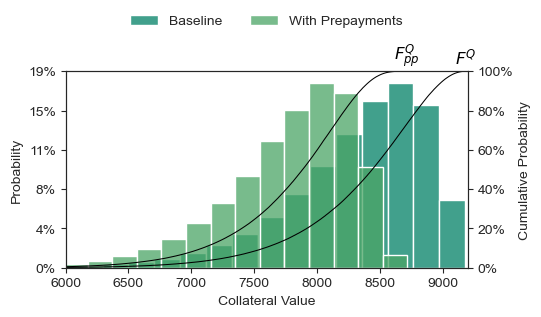

In [59]:
plt.figure(figsize=(textwidth, 9*cm))
palette = sns.color_palette("summer", n_colors=6, as_cmap=True)

simulations = SPV_Q
simulations_pp = SPV_Q_pp

min_ = 6000
max_ = 9200
ax = sns.histplot(data=simulations, bins=25, color=palette(1), stat='probability', alpha=0.75)
ax = sns.histplot(data=simulations_pp, bins=25, color=palette(75), stat='probability', alpha=0.75)

plt.ylabel("Probability")
maxy = round(ax.get_ylim()[1],2)

plt.ylim([0, maxy])
plt.yticks(np.linspace(0, maxy, 6),[str(int(round(x,2)*100))+"%" for x in np.linspace(0, maxy, 6)])

plt.legend(['Baseline','With Prepayments'],loc="upper center", bbox_to_anchor=(0.5, 1.35, 0, 0),ncol=2, frameon=False)
plt.xlim([min_,max_])
plt.xlabel("Collateral Value")

ax2 = ax.twinx()
ax2 = sns.ecdfplot(data=simulations, color='k',linewidth=0.75, ax=ax2, stat='proportion')
ax2 = sns.ecdfplot(data=simulations_pp, color='k',linewidth=0.75, ax=ax2, stat='proportion')

plt.text(np.quantile(simulations_pp, 1),1.075,s="$F^{Q}_{pp}$",ha='center',va='center',color='k',size=12)
plt.text(np.quantile(simulations, 1),1.075,s="$F^{Q}$",ha='center',va='center',color='k',size=12)

plt.ylabel("Cumulative Probability")
plt.ylim([0,1])
plt.yticks(np.linspace(0, 1, 6),["0%","20%","40%","60%","80%","100%"])

plt.tight_layout()

#plt.savefig("ColValwPP_Q.pdf", format='pdf', bbox_inches='tight')

plt.show()